<header>Preprocess</header>

In [4]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [17]:
%matplotlib inline

import numpy as np # linear algebra
olderr = np.seterr(all='ignore')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology, feature, filters
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

TestFlag = 1

In [6]:
def load_scan(path):
    slices = [pydicom.read_file(path +'/' + s, force= True) for s in os.listdir(path)]
    slices_bak = []
    for i in range(len(slices)):
        try:
            slices[i].ImagePositionPatient
            slices[i].file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
            slices_bak.append(slices[i])
        except:
            print("")
    slices = slices_bak
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # 转换为int16，int16是ok的，因为所有的数值都应该 <32k
    image = image.astype(np.int16)

    # 设置边界外的元素为0
    image[image == -2000] = 0

    # 转换为HU单位
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

In [8]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    if( (spacing / new_spacing).all() ==0):
        resize_factor=1
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [9]:
def plot_3d(image1, image2, threshold=-300):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image1.transpose(2,1,0)
    
    verts, faces,normals,values = measure.marching_cubes_lewiner(p, threshold)

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color1 = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color1)
    ax.add_collection3d(mesh)
    
    p = image2.transpose(2,1,0)
    
    verts, faces,normals,values = measure.marching_cubes_lewiner(p, threshold)

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color2 = [0.75, 0.45, 0.45]
    mesh.set_facecolor(face_color2)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

<header>Data Processing</header>

In [10]:
INPUT_FOLDER1 = 'D:\Software Project\RedACDS'
first_patient = load_scan(INPUT_FOLDER1)
first_patient_pixels = get_pixels_hu(first_patient)
first_pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])

INPUT_FOLDER2 = r'D:\Software Project\Red_1'
second_patient = load_scan(INPUT_FOLDER2)
second_patient_pixels = get_pixels_hu(second_patient)
second_pix_resampled, spacing = resample(second_patient_pixels, second_patient, [1,1,1])

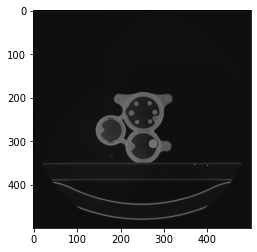

In [11]:
plt.imshow(second_pix_resampled[310], cmap=plt.cm.gray)

In [22]:
# normalize(array[l][m][n]): input a resampled CT clices, normalized all the slides(make the pixel value between 0 and 1),aims to find the canny of the image
# input: Array that contains all resampled CT images
# output: Array that contains normalized CT images

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

#unittest
if TestFlag == 1:
    #testcase one: check if a slice in first data set is normalized
    test_images = normalize(first_pix_resampled)
    index = 40
    test_image = test_images[index]
    for i in range(test_image.shape[0]):
        for j in range(test_image.shape[1]):
            assert(0 <= test_image[i][j] <= 1)
            
    #testcase two: check if a slice in second data set is normalized
    test_images = normalize(second_pix_resampled)
    index = 80
    test_image = test_images[index]
    for i in range(test_image.shape[0]):
        for j in range(test_image.shape[1]):
            assert(0 <= test_image[i][j] <= 1)
            

In [13]:

# extract canny of the slides
first_norm_images = normalize(first_pix_resampled)
first_edges = np.array([feature.canny(norm_image, sigma=3) for norm_image in first_norm_images])

second_norm_images = normalize(second_pix_resampled)
second_edges = np.array([feature.canny(norm_image, sigma=3) for norm_image in second_norm_images])

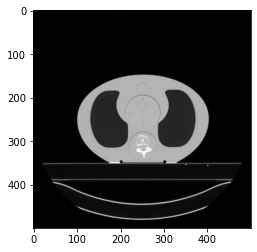

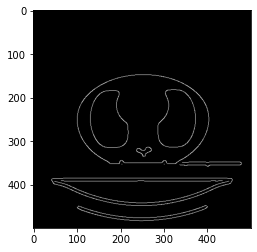

In [28]:
if TestFlag == 1:
    # compare the normalized image and the canny of it
    plt.imshow(second_norm_images[80], cmap=plt.cm.gray)
    plt.show()
    plt.imshow(second_edges[80], cmap=plt.cm.gray)

In [50]:
# threshold image(array[l][m][n], int, int): input the slides of CT data, lower bound and upper bound of the threshold; filter the unnecessary pixels outside the thresholds
# input: An array contains the slides of CT images, minimum value of the reserved pixels(default to be -300), upper bound of the reserved pixels(default to be 300)
# output: An array contains the slides of CT image which only reserve the pixels with value between the upper and lower thresholds

def threshold_image(image, thr_min=-300, thr_max=300):
    binary_mask1 = np.array(image > thr_min, dtype=np.int8)
    binary_mask2 = np.array(image < thr_max, dtype=np.int8)
    mask = (binary_mask1 + binary_mask2) > 1
    return mask

#unittest
if TestFlag == 1:
#testcase one: check if a threshold images of the first data set with default thresholds is valid
    test_images = first_pix_resampled
    index = 40
    thres_image = threshold_image(test_images)[index]
    for i in range(test_images.shape[1]):
        for j in range(test_images.shape[2]):
            assert( -300 < thres_image[i][j] and thres_image[i][j] < 300)

#testcase two: check if the threshold is adjustable
    test_images = second_pix_resampled
    index = 40
    thres_image = threshold_image(test_images,-200,200)[index]
    for i in range(test_images.shape[1]):
        for j in range(test_images.shape[2]):
            assert( -200 < thres_image[i][j] and thres_image[i][j] < 200)

# helper function, use to find the largest segment of the image
def largest_label_volume(im, bg=0):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    


<header>Couch Removel</header>

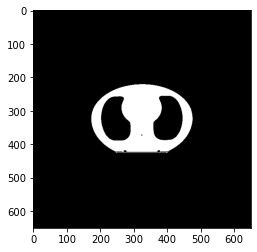

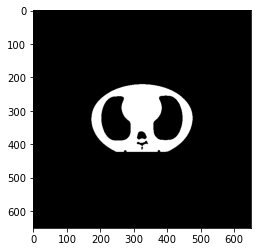

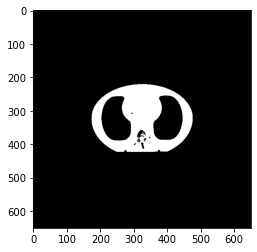

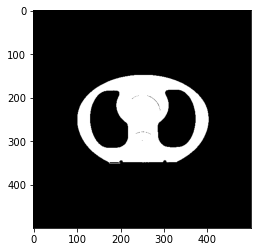

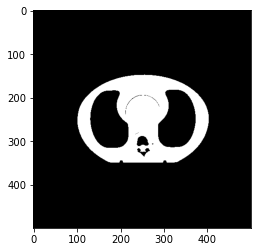

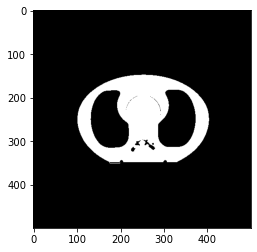

In [56]:
# segment_body_mask(array[l][m][n]): input the slides of CT data, remove the couch by outline the biggest part of the image
# input: An array contains the slides of CT images
# output: An array contains the slides of CT images, but obly reserve and fill the biggest object
def segment_body_mask(image):
    binary_image = threshold_image(image, -300, 300)
    
    for i, axial_slice in enumerate(binary_image):
        labeling = measure.label(axial_slice, background=0)
        l_max = largest_label_volume(labeling, bg=0)

        if l_max is not None:
            binary_image[i][labeling != l_max] = 0
                
    labels = measure.label(binary_image, background=0)
    
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    return binary_image


#unittest
if TestFlag == 1:
#testcase one: check if couch can be removed in the first data set
    index1 = 40
    index2 = 100
    index3 = 200
    mask_images = segment_body_mask(first_pix_resampled)
    plt.imshow(mask_images[index1], cmap=plt.cm.gray)
    plt.show()
    plt.imshow(mask_images[index2], cmap=plt.cm.gray)
    plt.show()
    plt.imshow(mask_images[index3], cmap=plt.cm.gray)
    plt.show()
    
#testcase two: check if couch can be removed in the second data set
    index1 = 50
    index2 = 150
    index3 = 250
    mask_images = segment_body_mask(second_pix_resampled)
    plt.imshow(mask_images[index1], cmap=plt.cm.gray)
    plt.show()
    plt.imshow(mask_images[index2], cmap=plt.cm.gray)
    plt.show()
    plt.imshow(mask_images[index3], cmap=plt.cm.gray)
    plt.show()
    


In [58]:
first_body_mask = segment_body_mask(first_pix_resampled)
second_body_mask = segment_body_mask(second_pix_resampled)

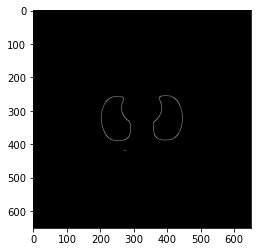

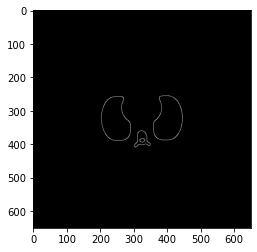

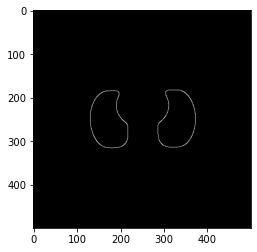

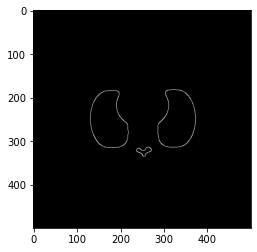

In [59]:
# extract_body_edges(array[l][m][n],array[l][m][n]): input the couch removed images and the canny of each images, outlines the detailed contours of the couch-removed images
# input: masks are the areas cover the couch-removed parts, edges are the cannies of the original CT images
# output: An array of images that show the detailed contours inside the CT images( already removed couch)
def extract_body_edges(masks, edges):
    for i in range(len(masks)):
        #print("Process %d" %i)
        contours = measure.find_contours(masks[i], 0)
        if len(contours) > 0:
            filled_mask = measure.grid_points_in_poly(masks[i].shape, contours[0])
            erode_mask = morphology.erosion(filled_mask, morphology.square(15))
            edges[i][erode_mask < 1] = 0
        else:
            edges[i] = 0
    return edges

#unittest
if TestFlag == 1:
#test case one: show if the contours can be printed in dataset 1
    first_contours = extract_body_edges(first_body_mask, first_edges)
    index1 = 40
    index2 = 80
    plt.imshow(first_contours[index1], cmap=plt.cm.gray)
    plt.show()
    plt.imshow(first_contours[index2], cmap=plt.cm.gray)
    plt.show()
#test case two: show if the contours can be printed in dataset 1
    second_contours = extract_body_edges(second_body_mask, second_edges)
    index1 = 40
    index2 = 80
    plt.imshow(second_contours[index1], cmap=plt.cm.gray)
    plt.show()
    plt.imshow(second_contours[index2], cmap=plt.cm.gray)
    plt.show()
    

In [60]:
first_body_edges = extract_body_edges(first_body_mask, first_edges)
second_body_edges = extract_body_edges(second_body_mask, second_edges)

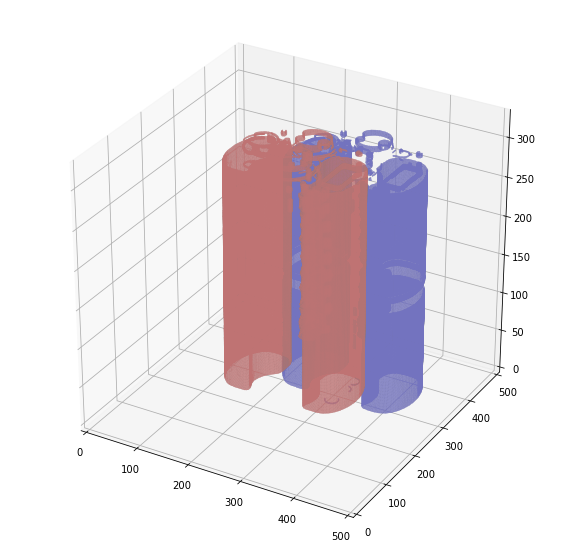

In [61]:
plot_3d(first_body_edges, second_body_edges, 0)

<header>Offfset Calculation</header>

In [63]:
# convert_edge2points (arrays[l][m][n]]): changes the processed CT contours into data points
# input: An array contains the contours of all CT images
# output: array that contains positions of the 3D data; center point of the 3d model

def convert_edge2points(edges):
    pts = np.array(np.where(edges > 0))
    num = pts.shape[1]
    center = pts.sum(axis = 1) / num
    return pts, center

#unittest
if TestFlag == 1:
#test case one: check the shape of the result
    first_pos, first_center = convert_edge2points(first_body_edges)
    assert(first_pos.shape[0] == 3)
    assert((len(first_center)) ==3)


In [48]:
first_pts, first_center = convert_edge2points(first_body_edges)
second_pts, second_center = convert_edge2points(second_body_edges)

first_pts[0,:] = first_pts[0,:] - first_center[0]
first_pts[1,:] = first_pts[1,:] - first_center[1]
first_pts[2,:] = first_pts[2,:] - first_center[2]
second_pts[0,:] = second_pts[0,:] - second_center[0]
second_pts[1,:] = second_pts[1,:] - second_center[1]
second_pts[2,:] = second_pts[2,:] - second_center[2]

In [49]:
print(first_pts.shape)
print(first_center)
print(second_center)

(3, 265522)
[154.47326775 333.14157396 323.8655554 ]
[165.82047658 260.01145812 250.88646208]


In [50]:
def plot_3d_points(pts1, pts2):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.scatter(pts1[2,:], pts1[1,:], pts1[0, :], s=0.02, c='red')
    ax.scatter(pts2[2,:], pts2[1,:], pts2[0, :], s=0.02, c='blue')

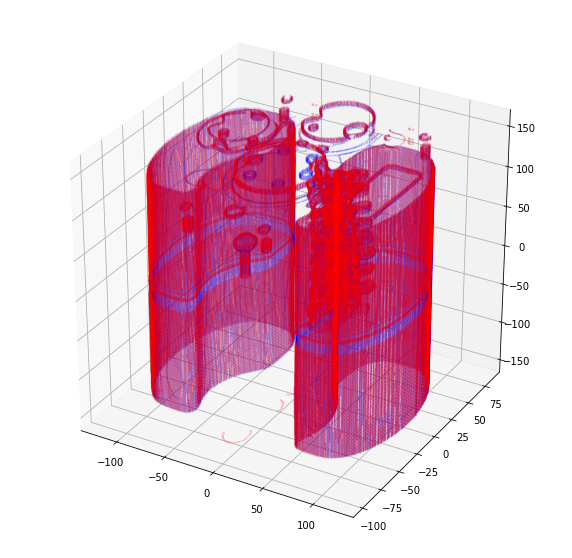

In [51]:
plot_3d_points(first_pts, second_pts)